In [1]:

!pip install gdown timm

import gdown
import zipfile
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import DataLoader, Subset
import torchvision.transforms as transforms
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from PIL import Image
import os
import timm
import numpy as np
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

# Download and extract dataset
file_id = '1jsMUDlvsXWQu2BansJz73mAErVyNg_g7'
destination = '/content/shared_file.zip'
gdown.download(id=file_id, output=destination, quiet=False)

# Check if the file is indeed a ZIP file
zip_path = '/content/shared_file.zip'

try:
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        print("ZIP file opened successfully.")
        zip_ref.extractall('/content')
    print("Extraction complete.")
except zipfile.BadZipFile:
    print("Error: The file is not a valid ZIP file or it is corrupted.")
except Exception as e:
    print(f"An unexpected error occurred: {e}")

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.5/47.5 kB 3.3 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.

Downloading...
From (original): https://drive.google.com/uc?id=1jsMUDlvsXWQu2BansJz73mAErVyNg_g7
From (redirected): https://drive.google.com/uc?id=1jsMUDlvsXWQu2BansJz73mAErVyNg_g7&confirm=t&uuid=14d2b07f-0cc9-4418-bfa4-c54ce7cf7fd9
To: /content/shared_file.zip
100%|██████████| 1.46G/1.46G [00:16<00:00, 86.2MB/s]


ZIP file opened successfully.
Extraction complete.
Using device: cuda


In [2]:

# Define constants
data_dirs = {
    'T4_Ptrain': ["l0", "l1", "l2"],
    'T4_Ptest': ["l0", "l1", "l2"]
}
data_root = "/content/T4_Pdata"  # Replace with the root directory of your data

# Create a list to store the paths and labels of all images
train_data = []
test_data = []

# Populate the list with paths and labels
for phase in data_dirs:
    for label, folder in enumerate(data_dirs[phase]):
        folder_path = os.path.join(data_root, phase, folder)
        image_files = os.listdir(folder_path)
        for image_file in image_files:
            image_path = os.path.join(folder_path, image_file)
            if phase == 'T4_Ptrain':
                train_data.append((image_path, label))
            else:
                test_data.append((image_path, label))

# Split train_data into training and validation sets while maintaining class distribution
train_data, val_data = train_test_split(train_data, test_size=0.2, stratify=[label for _, label in train_data])

# Define custom dataset class
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, data, transform=None):
        self.data = data
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path, label = self.data[idx]
        img = Image.open(img_path).convert('RGB')  # Open image and convert to RGB mode
        if self.transform:
            img = self.transform(img)
        label_tensor = torch.tensor(label, dtype=torch.long)  # Convert label to tensor
        return img, label_tensor

# Image preprocessing with augmentation for training
train_transform = transforms.Compose([
    transforms.Resize((240, 240)),
    transforms.RandomRotation(90),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ToTensor()
])

# Image preprocessing without augmentation for testing and validation
test_val_transform = transforms.Compose([
    transforms.Resize((300, 300)),
    transforms.ToTensor()
])

# Create custom datasets
train_dataset = CustomDataset(train_data, transform=train_transform)
val_dataset = CustomDataset(val_data, transform=test_val_transform)
test_dataset = CustomDataset(test_data, transform=test_val_transform)

# DataLoaders for batching and shuffling
batch_size = 32  # Define the batch size
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Load the Xception model
model = timm.create_model("hf_hub:timm/xception65.ra3_in1k", pretrained=True)

# Unfreeze all layers
for param in model.parameters():
    param.requires_grad = True

# Modify the final layer to match the number of classes in the dataset
num_classes = len(data_dirs['T4_Ptrain'])
model.fc = nn.Linear(model.fc.in_features, num_classes)

model.to(device)  # Move model to GPU

# Define optimizer and scheduler
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001)  # Set learning rate to 10^-3

scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10, verbose=True, min_lr=1e-6)  # Reduce factor, patience, and lower bound for LR

# Define loss function
criterion = nn.CrossEntropyLoss()


/usr/local/lib/python3.10/dist-packages/timm/models/_factory.py:117: UserWarning: Mapping deprecated model name xception to current legacy_xception.
  model = create_fn(
Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-cadene/xception-43020ad28.pth" to /root/.cache/torch/hub/checkpoints/xception-43020ad28.pth
/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


In [3]:

# Train the model
num_epochs = 100  # Set number of epochs to 100

# # Early stopping parameters
# early_stopping_patience = 15
# early_stopping_counter = 0
# best_val_loss = float('inf')

# Lists to store training and validation losses and accuracies
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

# Train the model
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    correct = 0
    total = 0
    progress_bar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}', leave=False)
    for images, labels in progress_bar:
        images, labels = images.to(device), labels.to(device)  # Move data to GPU
        optimizer.zero_grad()
        # Ensure the input tensor is passed correctly
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * labels.size(0)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        progress_bar.set_postfix({'Loss': train_loss / total, 'Accuracy': 100 * correct / total})

    train_loss = train_loss / len(train_loader.dataset)
    train_accuracy = 100 * correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    # Validation
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)  # Move data to GPU
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * labels.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_loss = val_loss / len(val_loader.dataset)
    val_accuracy = 100 * correct / total
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    print(f'Epoch {epoch+1}/{num_epochs}, '
          f'Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, '
          f'Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%')

    # Adjust learning rate
    scheduler.step(val_loss)

    # # Early stopping
    # if val_loss < best_val_loss:
    #     best_val_loss = val_loss
    #     early_stopping_counter = 0
    # else:
    #     early_stopping_counter += 1

    # if early_stopping_counter >= early_stopping_patience:
    #     print(f"Early stopping at epoch {epoch+1}")
    #     break

# Save the trained model
torch.save(model.state_dict(), '/content/xception_model.pth')


Epoch 1/100, Train Loss: 0.7840, Train Accuracy: 65.07%, Val Loss: 0.7557, Val Accuracy: 67.20%


Epoch 2/100, Train Loss: 0.6679, Train Accuracy: 70.45%, Val Loss: 0.6843, Val Accuracy: 71.97%


Epoch 3/100, Train Loss: 0.5495, Train Accuracy: 76.04%, Val Loss: 0.8114, Val Accuracy: 67.83%


Epoch 4/100, Train Loss: 0.5596, Train Accuracy: 76.32%, Val Loss: 0.6006, Val Accuracy: 75.16%


Epoch 5/100, Train Loss: 0.5117, Train Accuracy: 79.78%, Val Loss: 0.5422, Val Accuracy: 76.75%


Epoch 6/100, Train Loss: 0.4640, Train Accuracy: 81.10%, Val Loss: 0.7129, Val Accuracy: 74.36%


Epoch 7/100, Train Loss: 0.4163, Train Accuracy: 84.49%, Val Loss: 0.8836, Val Accuracy: 71.34%


Epoch 8/100, Train Loss: 0.3799, Train Accuracy: 84.65%, Val Loss: 0.4913, Val Accuracy: 81.69%


Epoch 9/100, Train Loss: 0.3848, Train Accuracy: 85.17%, Val Loss: 0.7222, Val Accuracy: 73.09%


Epoch 10/100, Train Loss: 0.3714, Train Accuracy: 85.85%, Val Loss: 0.5564, Val Accuracy: 79.62%


Epoch 11/100, Train Loss: 0.3341, Train Accuracy: 87.32%, Val Loss: 0.6634, Val Accuracy: 74.36%


Epoch 12/100, Train Loss: 0.3075, Train Accuracy: 88.76%, Val Loss: 0.8655, Val Accuracy: 71.34%


Epoch 13/100, Train Loss: 0.3241, Train Accuracy: 87.92%, Val Loss: 0.6651, Val Accuracy: 76.91%


Epoch 14/100, Train Loss: 0.3233, Train Accuracy: 87.56%, Val Loss: 0.6066, Val Accuracy: 80.73%


Epoch 15/100, Train Loss: 0.2623, Train Accuracy: 89.55%, Val Loss: 0.8695, Val Accuracy: 74.20%


Epoch 16/100, Train Loss: 0.3021, Train Accuracy: 89.04%, Val Loss: 0.8633, Val Accuracy: 75.96%


Epoch 17/100, Train Loss: 0.2691, Train Accuracy: 89.55%, Val Loss: 0.5122, Val Accuracy: 81.37%


Epoch 18/100, Train Loss: 0.2634, Train Accuracy: 89.55%, Val Loss: 0.7513, Val Accuracy: 75.48%


Epoch 19/100, Train Loss: 0.2203, Train Accuracy: 91.67%, Val Loss: 0.6701, Val Accuracy: 80.25%


Epoch 20/100, Train Loss: 0.1625, Train Accuracy: 93.66%, Val Loss: 0.5099, Val Accuracy: 86.46%


Epoch 21/100, Train Loss: 0.1301, Train Accuracy: 95.45%, Val Loss: 0.4693, Val Accuracy: 86.62%


Epoch 22/100, Train Loss: 0.1256, Train Accuracy: 95.93%, Val Loss: 0.5127, Val Accuracy: 86.78%


Epoch 23/100, Train Loss: 0.1061, Train Accuracy: 96.05%, Val Loss: 0.5086, Val Accuracy: 86.46%


Epoch 24/100, Train Loss: 0.0871, Train Accuracy: 96.61%, Val Loss: 0.4994, Val Accuracy: 86.94%


Epoch 25/100, Train Loss: 0.0965, Train Accuracy: 96.13%, Val Loss: 0.4868, Val Accuracy: 88.54%


Epoch 26/100, Train Loss: 0.0828, Train Accuracy: 96.85%, Val Loss: 0.4761, Val Accuracy: 87.90%


Epoch 27/100, Train Loss: 0.0881, Train Accuracy: 96.73%, Val Loss: 0.5223, Val Accuracy: 88.54%


Epoch 28/100, Train Loss: 0.0688, Train Accuracy: 97.57%, Val Loss: 0.5217, Val Accuracy: 87.90%


Epoch 29/100, Train Loss: 0.0779, Train Accuracy: 96.65%, Val Loss: 0.5659, Val Accuracy: 88.06%


Epoch 30/100, Train Loss: 0.0704, Train Accuracy: 97.41%, Val Loss: 0.5352, Val Accuracy: 88.69%


Epoch 31/100, Train Loss: 0.0602, Train Accuracy: 98.01%, Val Loss: 0.5460, Val Accuracy: 88.06%


Epoch 32/100, Train Loss: 0.0720, Train Accuracy: 97.61%, Val Loss: 0.5318, Val Accuracy: 88.38%


Epoch 33/100, Train Loss: 0.0533, Train Accuracy: 98.05%, Val Loss: 0.5304, Val Accuracy: 88.22%


Epoch 34/100, Train Loss: 0.0567, Train Accuracy: 98.05%, Val Loss: 0.5994, Val Accuracy: 87.58%


Epoch 35/100, Train Loss: 0.0483, Train Accuracy: 98.33%, Val Loss: 0.5854, Val Accuracy: 87.90%


Epoch 36/100, Train Loss: 0.0507, Train Accuracy: 97.93%, Val Loss: 0.5508, Val Accuracy: 87.74%


Epoch 37/100, Train Loss: 0.0439, Train Accuracy: 98.33%, Val Loss: 0.5539, Val Accuracy: 88.22%


Epoch 38/100, Train Loss: 0.0619, Train Accuracy: 97.37%, Val Loss: 0.5568, Val Accuracy: 88.06%


Epoch 39/100, Train Loss: 0.0548, Train Accuracy: 97.97%, Val Loss: 0.5395, Val Accuracy: 88.54%


Epoch 40/100, Train Loss: 0.0550, Train Accuracy: 98.37%, Val Loss: 0.5554, Val Accuracy: 88.69%


Epoch 41/100, Train Loss: 0.0569, Train Accuracy: 97.85%, Val Loss: 0.5702, Val Accuracy: 89.33%


Epoch 42/100, Train Loss: 0.0519, Train Accuracy: 98.25%, Val Loss: 0.6020, Val Accuracy: 87.26%


Epoch 43/100, Train Loss: 0.0387, Train Accuracy: 98.52%, Val Loss: 0.5897, Val Accuracy: 87.74%


Epoch 44/100, Train Loss: 0.0651, Train Accuracy: 97.77%, Val Loss: 0.5407, Val Accuracy: 88.22%


Epoch 45/100, Train Loss: 0.0403, Train Accuracy: 98.72%, Val Loss: 0.5672, Val Accuracy: 88.38%


Epoch 46/100, Train Loss: 0.0584, Train Accuracy: 97.73%, Val Loss: 0.5671, Val Accuracy: 88.38%


Epoch 47/100, Train Loss: 0.0525, Train Accuracy: 98.25%, Val Loss: 0.5520, Val Accuracy: 88.38%


Epoch 48/100, Train Loss: 0.0471, Train Accuracy: 98.29%, Val Loss: 0.5605, Val Accuracy: 87.90%


Epoch 49/100, Train Loss: 0.0479, Train Accuracy: 98.13%, Val Loss: 0.5545, Val Accuracy: 88.85%


Epoch 50/100, Train Loss: 0.0522, Train Accuracy: 98.29%, Val Loss: 0.5414, Val Accuracy: 88.22%


Epoch 51/100, Train Loss: 0.0485, Train Accuracy: 98.48%, Val Loss: 0.5454, Val Accuracy: 89.01%


Epoch 52/100, Train Loss: 0.0539, Train Accuracy: 97.77%, Val Loss: 0.5724, Val Accuracy: 87.42%


Epoch 53/100, Train Loss: 0.0538, Train Accuracy: 98.33%, Val Loss: 0.5505, Val Accuracy: 88.06%


Epoch 54/100, Train Loss: 0.0407, Train Accuracy: 98.56%, Val Loss: 0.5569, Val Accuracy: 87.90%


Epoch 55/100, Train Loss: 0.0481, Train Accuracy: 98.13%, Val Loss: 0.5605, Val Accuracy: 88.38%


Epoch 56/100, Train Loss: 0.0349, Train Accuracy: 99.08%, Val Loss: 0.5569, Val Accuracy: 88.06%


Epoch 57/100, Train Loss: 0.0565, Train Accuracy: 97.97%, Val Loss: 0.5385, Val Accuracy: 89.01%


Epoch 58/100, Train Loss: 0.0570, Train Accuracy: 97.85%, Val Loss: 0.5780, Val Accuracy: 88.22%


Epoch 59/100, Train Loss: 0.0524, Train Accuracy: 97.93%, Val Loss: 0.5830, Val Accuracy: 88.54%


Epoch 60/100, Train Loss: 0.0483, Train Accuracy: 98.41%, Val Loss: 0.5988, Val Accuracy: 86.62%


Epoch 61/100, Train Loss: 0.0463, Train Accuracy: 98.21%, Val Loss: 0.5450, Val Accuracy: 88.22%


Epoch 62/100, Train Loss: 0.0539, Train Accuracy: 97.93%, Val Loss: 0.5747, Val Accuracy: 87.90%


Epoch 63/100, Train Loss: 0.0407, Train Accuracy: 98.37%, Val Loss: 0.5320, Val Accuracy: 88.54%


Epoch 64/100, Train Loss: 0.0562, Train Accuracy: 97.77%, Val Loss: 0.5488, Val Accuracy: 88.22%


Epoch 65/100, Train Loss: 0.0595, Train Accuracy: 97.73%, Val Loss: 0.6084, Val Accuracy: 87.90%


Epoch 66/100, Train Loss: 0.0481, Train Accuracy: 98.21%, Val Loss: 0.5863, Val Accuracy: 87.74%


Epoch 67/100, Train Loss: 0.0461, Train Accuracy: 98.33%, Val Loss: 0.5826, Val Accuracy: 88.06%


Epoch 68/100, Train Loss: 0.0503, Train Accuracy: 98.01%, Val Loss: 0.5789, Val Accuracy: 87.74%


Epoch 69/100, Train Loss: 0.0522, Train Accuracy: 98.01%, Val Loss: 0.5947, Val Accuracy: 88.22%


Epoch 70/100, Train Loss: 0.0529, Train Accuracy: 98.05%, Val Loss: 0.5720, Val Accuracy: 87.90%


Epoch 71/100, Train Loss: 0.0504, Train Accuracy: 98.21%, Val Loss: 0.5616, Val Accuracy: 88.85%


Epoch 72/100, Train Loss: 0.0434, Train Accuracy: 98.56%, Val Loss: 0.5588, Val Accuracy: 88.54%


Epoch 73/100, Train Loss: 0.0553, Train Accuracy: 98.17%, Val Loss: 0.5877, Val Accuracy: 87.58%


Epoch 74/100, Train Loss: 0.0467, Train Accuracy: 98.37%, Val Loss: 0.5929, Val Accuracy: 88.69%


Epoch 75/100, Train Loss: 0.0467, Train Accuracy: 98.09%, Val Loss: 0.5550, Val Accuracy: 88.69%


Epoch 76/100, Train Loss: 0.0500, Train Accuracy: 98.41%, Val Loss: 0.5896, Val Accuracy: 87.58%


Epoch 77/100, Train Loss: 0.0446, Train Accuracy: 98.25%, Val Loss: 0.5694, Val Accuracy: 89.01%


Epoch 78/100, Train Loss: 0.0515, Train Accuracy: 98.13%, Val Loss: 0.5589, Val Accuracy: 88.69%


Epoch 79/100, Train Loss: 0.0521, Train Accuracy: 98.25%, Val Loss: 0.5688, Val Accuracy: 88.06%


Epoch 80/100, Train Loss: 0.0527, Train Accuracy: 98.25%, Val Loss: 0.5787, Val Accuracy: 88.69%


Epoch 81/100, Train Loss: 0.0367, Train Accuracy: 98.76%, Val Loss: 0.5419, Val Accuracy: 88.85%


Epoch 82/100, Train Loss: 0.0421, Train Accuracy: 98.41%, Val Loss: 0.5949, Val Accuracy: 87.90%


Epoch 83/100, Train Loss: 0.0440, Train Accuracy: 98.56%, Val Loss: 0.5624, Val Accuracy: 87.58%


Epoch 84/100, Train Loss: 0.0453, Train Accuracy: 98.41%, Val Loss: 0.5520, Val Accuracy: 88.69%


Epoch 85/100, Train Loss: 0.0416, Train Accuracy: 98.72%, Val Loss: 0.5466, Val Accuracy: 88.85%


Epoch 86/100, Train Loss: 0.0441, Train Accuracy: 98.29%, Val Loss: 0.5823, Val Accuracy: 88.38%


Epoch 87/100, Train Loss: 0.0499, Train Accuracy: 98.09%, Val Loss: 0.5935, Val Accuracy: 87.58%


Epoch 88/100, Train Loss: 0.0452, Train Accuracy: 98.37%, Val Loss: 0.5864, Val Accuracy: 87.90%


Epoch 89/100, Train Loss: 0.0470, Train Accuracy: 98.25%, Val Loss: 0.5902, Val Accuracy: 87.90%


Epoch 90/100, Train Loss: 0.0454, Train Accuracy: 98.48%, Val Loss: 0.5788, Val Accuracy: 88.85%


Epoch 91/100, Train Loss: 0.0501, Train Accuracy: 98.09%, Val Loss: 0.5678, Val Accuracy: 88.69%


Epoch 92/100, Train Loss: 0.0558, Train Accuracy: 98.09%, Val Loss: 0.5775, Val Accuracy: 88.38%


Epoch 93/100, Train Loss: 0.0452, Train Accuracy: 98.37%, Val Loss: 0.5768, Val Accuracy: 88.38%


Epoch 94/100, Train Loss: 0.0479, Train Accuracy: 98.13%, Val Loss: 0.5773, Val Accuracy: 88.69%


Epoch 95/100, Train Loss: 0.0481, Train Accuracy: 98.13%, Val Loss: 0.6019, Val Accuracy: 87.26%


Epoch 96/100, Train Loss: 0.0409, Train Accuracy: 98.80%, Val Loss: 0.5773, Val Accuracy: 88.85%


Epoch 97/100, Train Loss: 0.0449, Train Accuracy: 98.29%, Val Loss: 0.5761, Val Accuracy: 88.69%


Epoch 98/100, Train Loss: 0.0379, Train Accuracy: 98.76%, Val Loss: 0.5747, Val Accuracy: 87.90%


Epoch 99/100, Train Loss: 0.0415, Train Accuracy: 98.64%, Val Loss: 0.6124, Val Accuracy: 87.26%


Epoch 100/100, Train Loss: 0.0532, Train Accuracy: 97.89%, Val Loss: 0.5895, Val Accuracy: 88.54%


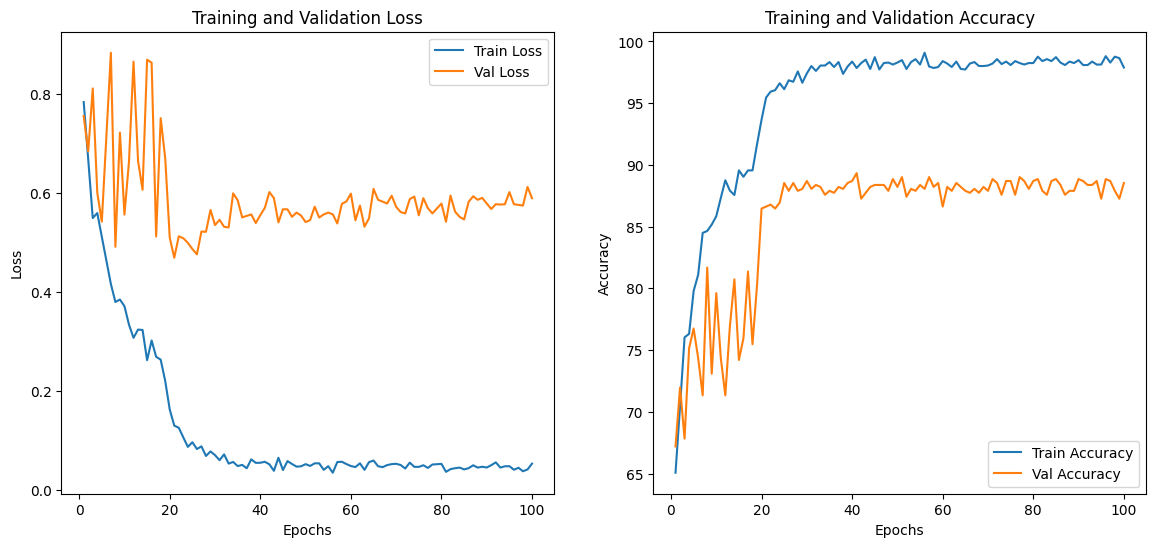

In [4]:

# Plotting training and validation losses and accuracies
epochs = range(1, len(train_losses) + 1)
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, val_losses, label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, label='Train Accuracy')
plt.plot(epochs, val_accuracies, label='Val Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.show()


In [5]:

# Test the model
model.eval()
test_correct = 0
test_total = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)  # Move data to GPU
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        test_total += labels.size(0)
        test_correct += (predicted == labels).sum().item()

test_accuracy = 100 * test_correct / test_total
print(f'Test Accuracy: {test_accuracy:.2f}%')

# Evaluate the model on the test set
model.eval()
predictions = []
true_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)  # Move data to GPU
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        predictions.extend(predicted.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

# Generate classification report
true_labels = np.array(true_labels)
predictions = np.array(predictions)
report = classification_report(true_labels, predictions, target_names=[f"Class {i}" for i in range(num_classes)])
print(report)


Test Accuracy: 88.84%
              precision    recall  f1-score   support

     Class 0       0.75      0.89      0.81       118
     Class 1       0.96      0.91      0.94       187
     Class 2       0.91      0.87      0.89       322

    accuracy                           0.89       627
   macro avg       0.87      0.89      0.88       627
weighted avg       0.89      0.89      0.89       627



In [7]:

from sklearn.metrics import confusion_matrix, balanced_accuracy_score

# Generate classification report and confusion matrix
print("Classification Report:")
print(classification_report(true_labels, predictions, target_names=[f"Class {i}" for i in range(num_classes)]))

cm = confusion_matrix(true_labels, predictions)
print("Confusion Matrix:")
print(cm)

# Calculate per-class metrics
TP = np.diag(cm)
FP = np.sum(cm, axis=0) - TP
FN = np.sum(cm, axis=1) - TP
TN = np.sum(cm) - (FP + FN + TP)

recall = TP / (TP + FN)
specificity = TN / (TN + FP)
precision = TP / (TP + FP)
f1_score = 2 * precision * recall / (precision + recall)

# Calculate macro-averaged metrics
macro_recall = np.mean(recall)
macro_precision = np.mean(precision)
macro_f1_score = np.mean(f1_score)
accuracy = np.sum(TP) / np.sum(cm)
balanced_accuracy = balanced_accuracy_score(true_labels, predictions)
custom_balanced_accuracy = np.mean((recall + specificity) / 2)

# Print class-wise metrics
print("\nClass-wise Metrics:")
for i in range(len(TP)):
    print(f"Class {i}:")
    print(f"  TP: {TP[i]}")
    print(f"  TN: {TN[i]}")
    print(f"  FP: {FP[i]}")
    print(f"  FN: {FN[i]}")
    print(f"  Recall: {recall[i]:.3f}")
    print(f"  Specificity: {specificity[i]:.3f}")
    print(f"  Precision: {precision[i]:.3f}")
    print(f"  F1-score: {f1_score[i]:.3f}")

# Print macro-averaged metrics
print("\nMacro-averaged Metrics:")
print(f"Macro Recall: {macro_recall:.3f}")
print(f"Macro Precision: {macro_precision:.3f}")
print(f"Macro F1-score: {macro_f1_score:.3f}")
print(f"Accuracy (ACC): {accuracy:.3f}")
print(f"Balanced Accuracy (BAC): {balanced_accuracy:.3f}")
print(f"Custom Balanced Accuracy (BCC): {custom_balanced_accuracy:.3f}")


Classification Report:
              precision    recall  f1-score   support

     Class 0       0.75      0.89      0.81       118
     Class 1       0.96      0.91      0.94       187
     Class 2       0.91      0.87      0.89       322

    accuracy                           0.89       627
   macro avg       0.87      0.89      0.88       627
weighted avg       0.89      0.89      0.89       627

Confusion Matrix:
[[105   0  13]
 [  1 171  15]
 [ 34   7 281]]

Class-wise Metrics:
Class 0:
  TP: 105
  TN: 474
  FP: 35
  FN: 13
  Recall: 0.890
  Specificity: 0.931
  Precision: 0.750
  F1-score: 0.814
Class 1:
  TP: 171
  TN: 433
  FP: 7
  FN: 16
  Recall: 0.914
  Specificity: 0.984
  Precision: 0.961
  F1-score: 0.937
Class 2:
  TP: 281
  TN: 277
  FP: 28
  FN: 41
  Recall: 0.873
  Specificity: 0.908
  Precision: 0.909
  F1-score: 0.891

Macro-averaged Metrics:
Macro Recall: 0.892
Macro Precision: 0.873
Macro F1-score: 0.881
Accuracy (ACC): 0.888
Balanced Accuracy (BAC): 0.892
Custom